In [3]:
%load_ext autoreload

Loading look-up table from ./lookuptables/Fe.mat
Computing force over all orientations


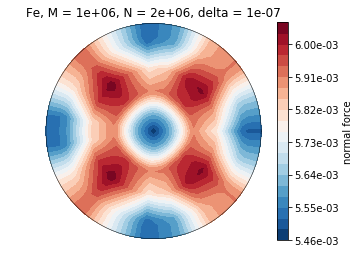

In [13]:
import numpy as np
from scipy.interpolate import interp2d
import scipy.io as sio
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%autoreload 2

from functions.elasticity_tensor import ElasticityTensor
from functions.plane_strain_modulus import PlaneStrainModulusTable
from functions.force import Force


'''
Parameters
'''

# Materials of body B1
Material_B1 = 'Fe'

# Gap function coefficients
M,N = 1e6,2e6

# Overlap distance
delta = 100e-9


'''
First, create an interpolant of plain strain modulus values for body B1
'''

SavePath = './stored_lookup_tables/'

# Check if look-up table of plane strain modulus values exists
if os.path.isfile(SavePath+Material_B1+'.mat'):
            
    # Load precomputed look-up table
    print('Loading look-up table from %s' % SavePath+Material_B1+'.mat')
    data = sio.loadmat(SavePath+Material_B1)
    EE,aa,bb = data['EE'],data['aa'].flatten(),data['bb'].flatten()
        
else:
            
    # Compute a look-up table of plane strain modulus values
    print('Computing a look-up table for %s' % Material_B1)
    C = ElasticityTensor(Material_B1)
    EE,aa,bb = PlaneStrainModulusTable(C,N_alpha=20,N_beta=10)
            
    # Save the look-up table for future use
    if not os.path.exists(SavePath): os.makedirs(SavePath)
    sio.savemat(SavePath+Material_B1,{'EE':EE,'aa':aa,'bb':bb})
    print('Look-up table for %s saved as' % SavePath+Material_B1+'.mat')
            
E_interp_B1 = interp2d(aa,bb,EE)

            
'''
Then, create an interpolant of plain strain modulus values for rigid body B2
'''

E_interp_B2 = interp2d(aa,bb,1e20*np.ones((len(bb),len(aa))))


'''                      
Finally, compute the force over all contact normal orientations 
'''

N_a,N_b = 100,25
aa = np.linspace(0,2*np.pi,N_a)
bb = np.linspace(0,np.pi/2,N_b)
FF = np.zeros((len(bb),len(aa)))

print('Computing force over all orientations')
for ia,a in enumerate(aa):
    for ib,b in enumerate(bb):
        
        print('Progress: %d%%\r'%((ia*N_b+(ib+1))/(N_a*N_b)*100), end="")
        
        # Coordinates of contact normal vector
        n = np.array([[np.cos(a)*np.sqrt(1-np.cos(b)**2)],
                      [np.sin(a)*np.sqrt(1-np.cos(b)**2)],
                      [np.cos(b)]])
        
        # Calculate contact force
        FF[ib,ia] = Force(E_interp_B1,E_interp_B2,np.eye(3),np.eye(3),M,N,delta,n)

        
# Plot the orientation-dependence of the force
AA,BB = np.meshgrid(aa,bb)
fig = plt.figure(figsize=[6,4])
ax = plt.gca()
ax.set_aspect('equal','box')
cs = ax.contourf(np.tan(BB/2)*np.cos(AA),np.tan(BB/2)*np.sin(AA),FF,levels=20,cmap="RdBu_r")
ax.plot(np.tan(bb[-1]/2)*np.cos(aa),np.tan(bb[-1]/2)*np.sin(aa),color='k',linewidth=0.5)
plt.gca().invert_yaxis()
plt.xlim(-np.tan(bb[-1]/2)*1.01,np.tan(bb[-1]/2)*1.01)
plt.ylim(-np.tan(bb[-1]/2)*1.01,np.tan(bb[-1]/2)*1.01)
plt.axis('off')
plt.title('%s, M = %g, N = %g, delta = %g' % (Material_B1,M,N,delta))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(cs, cax=cax, orientation="vertical", format='%.2e')
cbar.ax.set_ylabel('normal force')
plt.savefig('F_%s.pdf' % Material_B1)